# Basic Implementation

In [1]:
import numpy as np

In [11]:
class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[512, 512], output_size=10):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights = []
        self.biases = []

        # Input to Hidden Layers Network
        self.weights.append(0.01 * np.random.randn(input_size, hidden_layers[0]))
        self.biases.append(np.zeros((1, hidden_layers[0])))

        # Hidden Layers Network
        for i in range(len(hidden_layers)-1):
            self.weights.append(0.01 * np.random.randn(hidden_layers[i], hidden_layers[i+1]))
            self.biases.append(np.zeros((1, hidden_layers[i+1])))
        
        # Hidden Layers Network to Output
        self.weights.append(0.01 * np.random.randn(hidden_layers[len(hidden_layers)-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    def forward(self, inputs):
        layers = [inputs]

        for i in range(len(self.weights)):
            # Dot Product to 
            layers.append(np.dot(layers[-1], self.weights[i]) + self.biases[i])

            # Activation Functions (ReLU + SoftMax)
            if i == len(self.weights)-1:
                finalOutput = np.exp(layers[-1] - np.max(layers[-1], axis=1, keepdims=True))
                finalOutput = finalOutput / np.sum(finalOutput, axis=1, keepdims=True)
                layers.append(finalOutput)
            else:
                layers.append(np.maximum(0, layers[-1]))
        
        return layers[-1]


In [12]:
# LossCategoricalCrossEntropy implementation
def LossCategoricalCrossEntropy(yPred, yTrue):
    # If predicted class has a prediction of 0% likelihood this prevents log(0), which would be infinity
    yPred = np.clip(yPred, 1e-10, 1 - 1e-10)

    # We calculate the sum of the log losses
    loss = -np.sum(yTrue * np.log(yPred), axis=1)

    # We calculate the average loss - this depends on the number of samples
    # So the return loss is the average loss not the summed up loss (which took me a while to understand)
    average_loss = np.mean(loss)

    return average_loss


In [4]:
myNeuralNet = NeuralNetwork()

In [5]:
result = myNeuralNet.forward(np.random.rand(1, 784))
result

array([[0.10015088, 0.09973115, 0.10015047, 0.10023912, 0.10032136,
        0.0997335 , 0.09989479, 0.09979533, 0.09986623, 0.10011717]])

# Get Weights from PyTorch Model

In [6]:
modelMNIST = NeuralNetwork(hidden_layers=[256])

In [7]:
# Import Weights from Folder
modelWeights = []
modelWeights.append(np.load("./modelWeights/layer_stack.1.weight.npy"))
modelWeights.append(np.load("./modelWeights/layer_stack.3.weight.npy"))
modelBiases = []
modelBiases.append(np.load("./modelWeights/layer_stack.1.bias.npy"))
modelBiases.append(np.load("./modelWeights/layer_stack.3.bias.npy"))

In [8]:
# Visualize Biases:
for i in range(len(modelBiases)):
    print(f"Shapes PytTorchModel: {modelBiases[i].shape}")
    print(f"Shapes PytTorchModel Transformed: {np.expand_dims(modelBiases[i], axis=0).shape}")
    print(f"Shapes MyModel: {modelMNIST.biases[i].shape}")
    print()

# Visualize Weights:
for i in range(len(modelWeights)):
    print(f"Shapes PytTorchModel: {modelWeights[i].shape}")
    print(f"Shapes PytTorchModel Transformed: {modelWeights[i].T.shape}")
    print(f"Shapes MyModel: {modelMNIST.weights[i].shape}")
    print()

Shapes PytTorchModel: (256,)
Shapes PytTorchModel Transformed: (1, 256)
Shapes MyModel: (1, 256)

Shapes PytTorchModel: (10,)
Shapes PytTorchModel Transformed: (1, 10)
Shapes MyModel: (1, 10)

Shapes PytTorchModel: (256, 784)
Shapes PytTorchModel Transformed: (784, 256)
Shapes MyModel: (784, 256)

Shapes PytTorchModel: (10, 256)
Shapes PytTorchModel Transformed: (256, 10)
Shapes MyModel: (256, 10)



In [9]:
# Change Biases:
for i in range(len(modelBiases)):
    modelMNIST.biases[i] = np.expand_dims(modelBiases[i], axis=0)

# Change Weights:
for i in range(len(modelWeights)):
    modelMNIST.weights[i] = modelWeights[i].T

In [2]:
import gzip

# Load MNIST dataset
def extract_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=np.uint32, count=4).byteswap()
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def extract_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num = np.frombuffer(f.read(8), dtype=np.uint32, count=2).byteswap()
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images = extract_images("./MNISTdata/train-images-idx3-ubyte.gz")
train_labels = extract_labels("./MNISTdata/train-labels-idx1-ubyte.gz")
test_images = extract_images("./MNISTdata/t10k-images-idx3-ubyte.gz")
test_labels = extract_labels("./MNISTdata/t10k-labels-idx1-ubyte.gz")

In [11]:
testImage1 = np.expand_dims(test_images[0].flatten(), axis=0)
print(f"Test Label: {test_labels[0]}")
print(f"Predicted Label: {modelMNIST.forward(testImage1)}")

Test Label: 7
Predicted Label: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [12]:
correct = 0
incorrect = 0
for i in range(len(test_images)):
    image = np.expand_dims(test_images[i].flatten(), axis=0)

    if int(test_labels[i]) == int(modelMNIST.forward(image).argmax()):
        correct += 1
    else:
        incorrect += 1

(correct)/(correct+incorrect)

0.9753

# Implement Backpropagation

In [52]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[512, 512], output_size=10):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights = []
        self.biases = []
        self.gradientsWeights = []
        self.gradientsBiases = []
        self.iterations = 0

        # Input to Hidden Layers Network
        # np.random.seed(0)
        self.weights.append(0.01 * np.random.randn(input_size, hidden_layers[0]))
        self.biases.append(np.zeros((1, hidden_layers[0])))

        # Hidden Layers Network
        for i in range(len(hidden_layers)-1):
            # np.random.seed(0)
            self.weights.append(0.01 * np.random.randn(hidden_layers[i], hidden_layers[i+1]))
            self.biases.append(np.zeros((1, hidden_layers[i+1])))
        
        # Hidden Layers Network to Output
        # np.random.seed(0)
        self.weights.append(0.01 * np.random.randn(hidden_layers[len(hidden_layers)-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    def forward(self, inputs):
        self.outputs = [inputs]
        self.outputsTesting = ["inputs"]

        for i in range(len(self.weights)):
            # Dot Product to 
            self.outputs.append(np.dot(self.outputs[-1], self.weights[i]) + self.biases[i])
            self.outputsTesting.append("dense")

            # Activation Functions (ReLU + SoftMax)
            if i == len(self.weights)-1:
                finalOutput = np.exp(self.outputs[-1] - np.max(self.outputs[-1], axis=1, keepdims=True))
                finalOutput = finalOutput / np.sum(finalOutput, axis=1, keepdims=True)
                self.outputs.append(finalOutput)
                self.outputsTesting.append("softmax")
            else:
                self.outputs.append(np.maximum(0, self.outputs[-1]))
                self.outputsTesting.append("relu")
        
        return self.outputs[-1]
    
    def backwards(self, y_true):
        # Softmax + LossCategoricalEntropy 
        #       -> Still don't fully understand the derivation for this (working on it)
        #       -> I roughly understand the following code but it was extracted from the nnfs textbook
        #       -> nnfs textBook -> https://nnfs.io/

        # Number of samples
        samples = len(self.outputs[-1])

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            print("Chaning to Discrete Values")
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        dSoftMaxCrossEntropy = self.outputs[-1].copy()
        # Calculate gradient
        dSoftMaxCrossEntropy[range(samples), y_true] -= 1
        # Normalize gradient
        dSoftMaxCrossEntropy = dSoftMaxCrossEntropy / samples
        # print(dSoftMaxCrossEntropy)

        # print(dSoftMaxCrossEntropy)
        # Calculate gradients -> Calcualte derivative of weights, biases, and inputs (to continue to backpropagate)
        dInputs = np.dot(dSoftMaxCrossEntropy.copy(), self.weights[-1].T)

        dWeights = np.dot(self.outputs[-3].T, dSoftMaxCrossEntropy.copy())
        dBiases = np.sum(dSoftMaxCrossEntropy.copy(), axis=0, keepdims=True)
        self.gradientsWeights = [dWeights] + self.gradientsWeights
        self.gradientsBiases = [dBiases] + self.gradientsBiases


        i = -3
        j = -1
        for _ in range(len(self.hidden_layers)):
            i -= 1
            j -= 1
            
            # ReLU activation Function
            dInputsReLU = dInputs.copy()
            dInputsReLU[self.outputs[i] <= 0] = 0
            
            i -= 1
            dInputs = np.dot(dInputsReLU, self.weights[j].T)
            dWeights = np.dot(self.outputs[i].T, dInputsReLU)
            dBiases = np.sum(dInputsReLU, axis=0, keepdims=True)
            self.gradientsWeights = [dWeights] + self.gradientsWeights
            self.gradientsBiases = [dBiases] + self.gradientsBiases

        # print("dense1.dweights")
        # print(dWeights)
        # print(dWeights.shape)
        # print("dense1.dbiases")
        # print(dBiases)
        # print(dBiases.shape)
    
    def updateParams(self, lr=0.05, decay=1e-7):
        lr = lr * (1. / (1. + decay * self.iterations))
        # print(f"Learning Rate: {lr}")
        # print(self.iterations)

        for i in range(len(self.weights)):
            if i != len(self.weights)-1:
                assert self.weights[i].shape == self.gradientsWeights[i].shape
                self.weights[i] += -lr*self.gradientsWeights[i]
        
        for i in range(len(self.biases)):
            if i != len(self.biases)-1:
                assert self.biases[i].shape == self.gradientsBiases[i].shape
                self.biases[i] += -lr*self.gradientsBiases[i]
        
        # print(f"Learning Rate: {lr}")
        
        self.iterations += 1

# LossCategoricalCrossEntropy implementation
def LossCategoricalCrossEntropy(yPred, yTrue):
    # If predicted class has a prediction of 0% likelihood this prevents log(0), which would be infinity
    yPred = np.clip(yPred, 1e-10, 1 - 1e-10)

    # We calculate the sum of the log losses
    loss = -np.sum(yTrue * np.log(yPred), axis=1)

    # We calculate the average loss - this depends on the number of samples
    # So the return loss is the average loss not the summed up loss (which took me a while to understand)
    average_loss = np.mean(loss)

    return average_loss

def sparse_to_one_hot(sparse_labels, num_classes):
    one_hot_encoded = np.zeros((len(sparse_labels), num_classes))
    one_hot_encoded[np.arange(len(sparse_labels)), sparse_labels] = 1
    return one_hot_encoded


In [41]:
len(myNeuralNet.outputs)

5

In [53]:
myNeuralNet = NeuralNetwork(hidden_layers=[128, 128])

In [54]:
train_images = extract_images("./MNISTdata/train-images-idx3-ubyte.gz")
train_labels = extract_labels("./MNISTdata/train-labels-idx1-ubyte.gz")
test_images = extract_images("./MNISTdata/t10k-images-idx3-ubyte.gz")
test_labels = extract_labels("./MNISTdata/t10k-labels-idx1-ubyte.gz")

# Testing with my Own Model

In [16]:
# data = train_images
# dataLabels = train_labels

# # Normalize
# data = (data.astype(np.float32)-127.5)/127.5

# data = data.reshape(60000, 784)

# accuracies = []
# losses = []

# BATCH_SIZE = 32

# train_steps = len(data) // BATCH_SIZE
# step = 0

In [17]:
# # One epoch
# batch_X = data[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
# batch_y = dataLabels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]

# X = batch_X
# y = batch_y

# output = myNeuralNet.forward(X)

# if step % 1 == 0:
#     predictions = np.argmax(output, axis=1)
#     if len(y.shape) == 2:
#         y = np.argmax(y, axis=1)
#     accuracy = np.mean(predictions==y)

#     loss = LossCategoricalCrossEntropy(output, sparse_to_one_hot(y, 10))
#     accuracies.append(accuracy)
#     losses.append(loss)

#     print(f'epoch: {epoch}, ' +
#             f'acc: {accuracy:.3f}, ' +
#             f'loss: {loss:.3f}')

# # Backward pass
# myNeuralNet.backwards(y)

# # Update weights and biases
# myNeuralNet.updateParams(lr=0.8, decay=1e-6)

# step += 1

# Working Implementation

In [55]:
data = train_images
dataLabels = train_labels

# Normalize
data = (data.astype(np.float32)-127.5)/127.5

data = data.reshape(60000, 784)

accuracies = []
losses = []

BATCH_SIZE = 32

# Main training loop
for epoch in range(1, 5):
    print(f'epoch: {epoch}')
    train_steps = len(data) // BATCH_SIZE

    for step in range(train_steps):
        batch_X = data[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        batch_y = dataLabels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]

        X = batch_X
        y = batch_y

        output = myNeuralNet.forward(X)

        if step % 100 == 0:
            predictions = np.argmax(output, axis=1)
            if len(y.shape) == 2:
                y = np.argmax(y, axis=1)
            accuracy = np.mean(predictions==y)

            loss = LossCategoricalCrossEntropy(output, sparse_to_one_hot(y, 10))
            accuracies.append(accuracy)
            losses.append(loss)

            print(f'epoch: {epoch}, ' +
                    f'acc: {accuracy:.3f}, ' +
                    f'loss: {loss:.3f}')
        
        # Backward pass
        myNeuralNet.backwards(y)

        # Update weights and biases
        myNeuralNet.updateParams(lr=0.5, decay=1e-6)

epoch: 1
epoch: 1, acc: 0.125, loss: 2.303
epoch: 1, acc: 0.469, loss: 1.593
epoch: 1, acc: 0.781, loss: 0.645
epoch: 1, acc: 0.750, loss: 0.737
epoch: 1, acc: 0.906, loss: 0.424
epoch: 1, acc: 0.875, loss: 0.544
epoch: 1, acc: 0.844, loss: 0.269
epoch: 1, acc: 0.938, loss: 0.214
epoch: 1, acc: 0.906, loss: 0.302
epoch: 1, acc: 0.906, loss: 0.238
epoch: 1, acc: 0.875, loss: 0.363
epoch: 1, acc: 0.906, loss: 0.379
epoch: 1, acc: 0.906, loss: 0.249
epoch: 1, acc: 0.875, loss: 0.444
epoch: 1, acc: 0.906, loss: 0.238
epoch: 1, acc: 0.938, loss: 0.235
epoch: 1, acc: 0.875, loss: 0.302
epoch: 1, acc: 0.906, loss: 0.229
epoch: 1, acc: 0.938, loss: 0.224
epoch: 2
epoch: 2, acc: 0.969, loss: 0.187
epoch: 2, acc: 0.875, loss: 0.381
epoch: 2, acc: 0.938, loss: 0.205
epoch: 2, acc: 1.000, loss: 0.062
epoch: 2, acc: 0.969, loss: 0.137
epoch: 2, acc: 0.875, loss: 0.258
epoch: 2, acc: 0.875, loss: 0.203
epoch: 2, acc: 0.969, loss: 0.106
epoch: 2, acc: 0.969, loss: 0.108
epoch: 2, acc: 0.969, loss: 0.

In [56]:
dataTest = test_images
dataTestLabels = test_labels

# Normalize
dataTest = (dataTest.astype(np.float32)-127.5)/127.5
print(dataTest.shape)
dataTest = dataTest.reshape(10000, 784)

X = dataTest
y = dataTestLabels

output = myNeuralNet.forward(dataTest)

predictions = np.argmax(output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)
print(accuracy)

(10000, 28, 28)
0.9641


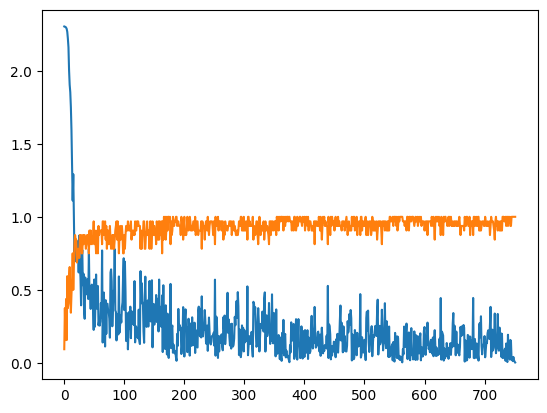

In [32]:
import matplotlib.pyplot as mp

mp.plot(losses)
mp.plot(accuracies)

# Notes

(batchNumber[32], inputs[718]) * (weights[718], weights[512]) = (32, 512)

- Implement GitHub Repo - DONE

Forward pass - Train 
    - Neurons + - DONE
    - Acitvation function + - DONE
    - Softwax (get probablities) + - DONE
    - loss - DONE
    - Test Forward Pass with Other Model Gradients - DONE

Implement backpropagation
    - Explain how to do and everything
    - Start training with basic 80-20

Introduce regularization
Batch Normalization

Optimizer

Visualize gradients

Visualize MNIST with UMAP or T-SNE